In [ ]:
log_path = 'negative_possibility/2025-12-03/11-56-47'
log_path2 = "negative_possibility/2025-12-01/"
# # log_path3 = 'Square_distance/2025-11-28/10-59-04'
# match_log = 'fixed_value/2025-10-24/16-59-25'
log_name = 'fixed_value_training.log'

# log_path = 'DSGD_shinkhorn/2025-11-28'
# log_path2 = "DSGD_metropolis_hasting/2025-10-22/18-17-52"
# log_path3 = 'DSGD_maximum_degree_lr_decay/2025-10-24/11-29-49'
# match_log = 'matcha_lr_decay/2025-10-28/17-26-25'
# log_name = 'main.log'
import numpy as np
import re
import os
from omegaconf import OmegaConf
from flp2p.utils import compute_weight_matrix
import networkx as nx
import pickle
from flp2p.matcha_mixing_matrix import getAlpha, getProbability, getSubGraphs, graphToLaplacian

def get_metrics(data):
    overall_distance_p = re.compile(r'Overall consensus distance : ([\d\.]+)')
    inter_cluster_distance_p = re.compile(r'Inter-cluster distance : ([\d\.]+)')
    cluster_1_distance_p =  re.compile(r'Cluster 1 consensus distance : ([\d\.]+)')
    cluster_2_distance_p =  re.compile(r'Cluster 2 consensus distance : ([\d\.]+)')
    spectral_gap_p = re.compile(r'Spectral Gap = ([\d\.]+)')
    test_pattern = re.compile(r"Test, Round (\d+) : loss => ([\d\.]+),  accuracy: ([\d\.]+)")
    train_pattern = re.compile(r"Train, Round (\d+) : loss => ([\d\.]+),  accuracy: ([\d\.]+)")
    gradient_norm_pattern = re.compile(r"Train, Round(\d+) : gradient_norm : ([\d\.]+)")
    
    overall_distance, inter_cluster_distance, cluster_1_distance, cluster_2_distance, spectral_gap = [], [], [], [], []
    test_accuracy, train_loss, test_loss = [], [], []
    for match in overall_distance_p.finditer(data):
        overall_distance.append(float(match.group(1)))
        
    for match in inter_cluster_distance_p.finditer(data):
        inter_cluster_distance.append(float(match.group(1)))
    
    for match in cluster_1_distance_p.finditer(data):
        cluster_1_distance.append(float(match.group(1)))
           
    for match in cluster_2_distance_p.finditer(data):
        cluster_2_distance.append(float(match.group(1)))
        
    for match in spectral_gap_p.finditer(data):
        spectral_gap.append(float(match.group(1)))
        
    for match in test_pattern.finditer(data):
        test_accuracy.append(float(match.group(3)))

    return {"consensus_distance": overall_distance,
            "inter_cluster_distance": inter_cluster_distance,
            "cluster_1_distance": cluster_1_distance,
            "cluster_2_distance": cluster_2_distance,
            "spectral_gap": spectral_gap,
            'test_accuracy': test_accuracy}
    
def extract_res(log_file, results, log_name):
    with open(f'{log_file}/{log_name}', 'r') as f:
        data = f.read()
    config_file = OmegaConf.load(f'{log_file}/.hydra/config.yaml') 
    with open(f'{log_file}/graph.pickle', 'rb') as f:
        graph = pickle.load(f)
            
    W = compute_weight_matrix(graph, config_file.mixing_matrix)
    eigenval = sorted(np.linalg.eig(W).eigenvalues, reverse=True)
    algebric_value = 1 - max(abs(eigenval[1]), abs(eigenval[-1]))
    res_dict = get_metrics(data)
    dict_key  =f'{log_file.split('/')[-2]}_{log_file.split('/')[-1]}_{config_file.mixing_matrix}'
    results[dict_key] = res_dict
    results[dict_key]['main_link_activation'] = config_file.main_link_activation
    results[dict_key]['border_link_activation'] = config_file.border_link_activation
    if results[dict_key]['main_link_activation'] == 1:
        results[dict_key]['old_gradients'] = True
    results[dict_key]['old_gradients'] = config_file.old_gradients


results = {}
for root, dirs, files in os.walk(log_path):
    print(files)
    if log_name in files:
        log_file_path = root
        extract_res(log_file_path, results, log_name)
   

for root, dirs, files in os.walk(log_path2):
    if log_name in files:
        log_file_path = root
        extract_res(log_file_path, results, log_name)
        

# for root, dirs, files in os.walk(log_path3):
#     if log_name in files:
#         log_file_path = root
#         extract_res(log_file_path, results, log_name)
        

# for root, dirs, files in os.walk(match_log):
#     if log_name in files:
#         log_file_path = root
#         extract_res(log_file_path, results, log_name)

['multirun.yaml']
['graph_topology.html', 'graph.pickle', 'fixed_value_training.log']
['overrides.yaml', 'hydra.yaml', 'config.yaml']
['graph_topology.html', 'graph.pickle', 'fixed_value_training.log']
['overrides.yaml', 'hydra.yaml', 'config.yaml']
['graph_topology.html', 'graph.pickle', 'fixed_value_training.log']
['overrides.yaml', 'hydra.yaml', 'config.yaml']
['graph_topology.html', 'graph.pickle', 'fixed_value_training.log']
['overrides.yaml', 'hydra.yaml', 'config.yaml']
['graph_topology.html', 'graph.pickle', 'fixed_value_training.log']
['overrides.yaml', 'hydra.yaml', 'config.yaml']
['graph_topology.html', 'graph.pickle', 'fixed_value_training.log']
['overrides.yaml', 'hydra.yaml', 'config.yaml']


In [2]:
list(results.keys())

['2025-12-01_17-21-27_jaccard',
 '10-04-38_maximum_degree-False-lenet5_maximum_degree',
 '10-04-38_maximum_degree-True-lenet5_maximum_degree',
 '10-04-38_metropolis_hasting-False-lenet5_metropolis_hasting',
 '10-04-38_metropolis_hasting-True-lenet5_metropolis_hasting',
 '2025-10-24_16-59-25_matcha']

In [32]:
results['2025-11-28_12-02-02_jaccard']['test_accuracy']

[0.1,
 0.194,
 0.2057,
 0.2227,
 0.2268,
 0.2346,
 0.2581,
 0.269,
 0.3258,
 0.331,
 0.3356,
 0.3805,
 0.3947,
 0.4025,
 0.4158,
 0.4167,
 0.42,
 0.4353,
 0.4556,
 0.4989,
 0.493,
 0.5039,
 0.546,
 0.5547,
 0.5727,
 0.565,
 0.5693,
 0.5768,
 0.573,
 0.5842,
 0.5872,
 0.5786,
 0.5933,
 0.59,
 0.5864,
 0.5928,
 0.5853,
 0.5865,
 0.5857,
 0.5872,
 0.5853,
 0.5931,
 0.5898,
 0.5848,
 0.5996,
 0.5933,
 0.5902,
 0.6006,
 0.6031,
 0.5953,
 0.5985,
 0.6059,
 0.6059,
 0.6103,
 0.6062,
 0.6012,
 0.6108,
 0.6214,
 0.6221,
 0.6307,
 0.621,
 0.6201,
 0.6282,
 0.6147,
 0.6153,
 0.6375,
 0.6216,
 0.6175,
 0.6239,
 0.6159,
 0.625,
 0.6153,
 0.6259,
 0.6255,
 0.6213,
 0.6148,
 0.6112,
 0.6297,
 0.6316,
 0.6268,
 0.6338,
 0.6219,
 0.6202,
 0.6235,
 0.6099,
 0.6366,
 0.6196,
 0.6319,
 0.6261,
 0.6133,
 0.6133,
 0.6186,
 0.62,
 0.6195,
 0.6192,
 0.612,
 0.6077,
 0.6324,
 0.6323,
 0.5953,
 0.6215,
 0.615,
 0.6143,
 0.6222,
 0.6209,
 0.6197,
 0.6197,
 0.6183,
 0.6273,
 0.6266,
 0.628,
 0.6361,
 0.6301,
 0.6

consensus_distance
consensus_distance
consensus_distance
consensus_distance
consensus_distance
consensus_distance


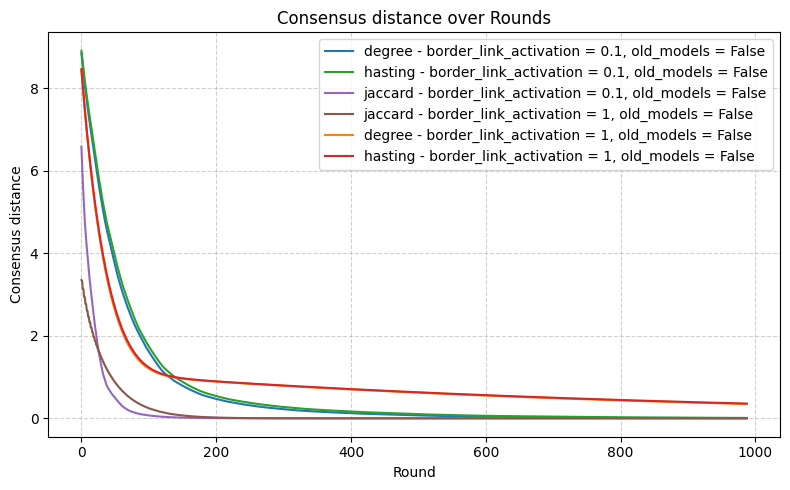

inter_cluster_distance
inter_cluster_distance
inter_cluster_distance
inter_cluster_distance
inter_cluster_distance
inter_cluster_distance


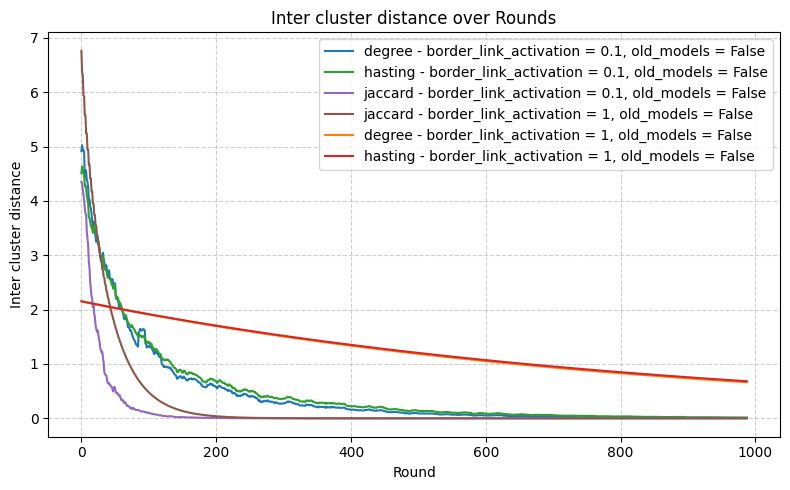

cluster_1_distance
cluster_1_distance
cluster_1_distance
cluster_1_distance
cluster_1_distance
cluster_1_distance


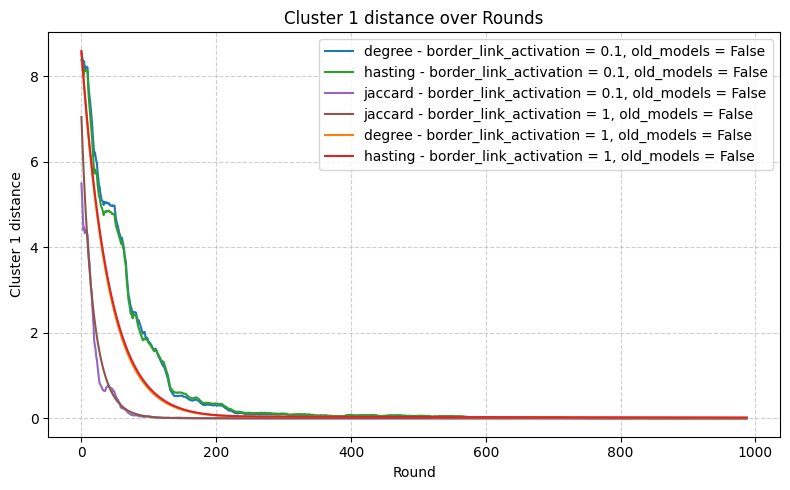

cluster_2_distance
cluster_2_distance
cluster_2_distance
cluster_2_distance
cluster_2_distance
cluster_2_distance


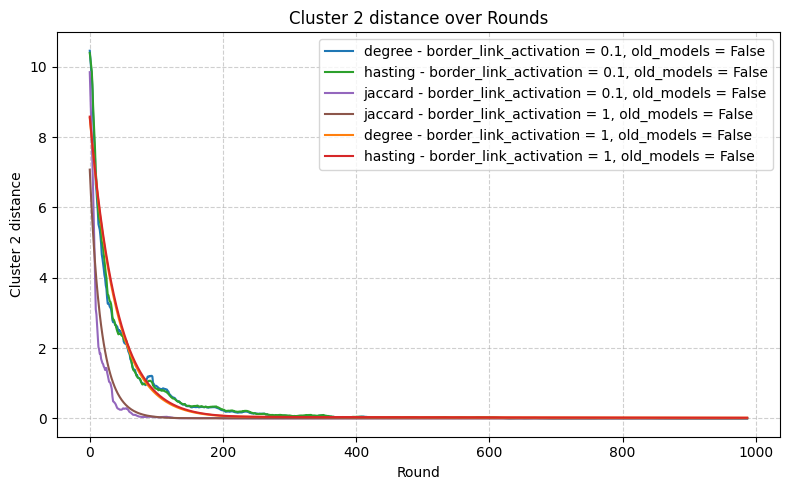

spectral_gap
spectral_gap
spectral_gap
spectral_gap
spectral_gap
spectral_gap


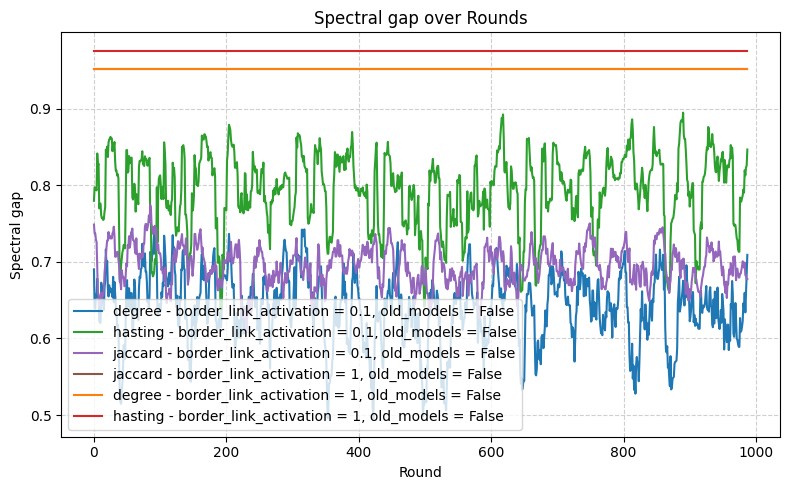

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
keys = list(results.keys())
index_elems = list(results[keys[0]].keys())
epochs = min(1000, min(len(results[k][index_elems[0]]) for k in keys)) 
start = 0
unique_old_gradients = sorted(set(f"{results[k]['old_gradients']}-{k.split('_')[-1]}-{results[k]['border_link_activation']}" for k in results.keys()))
color_cycle = plt.cm.tab10.colors  # 10 distinct colors (you can use more: tab20, viridis, etc.)
color_map = {og: color_cycle[i % len(color_cycle)] for i, og in enumerate(unique_old_gradients)}
for index_elem in index_elems:
    plt.figure(figsize=(8, 5))
    if type(results[list(results.keys())[0]][index_elem]) is not list or len(results[list(results.keys())[0]][index_elem]) == 0:
        continue
    for key in keys:
        if results[key]["old_gradients"] is False:
            y = results[key][index_elem]
            print(index_elem)
            y = np.convolve(y[start:epochs], np.ones(10)/10)[10:-10]
            rounds = np.arange(start, start + len(y))
            g_matrix = key.split('_')[-1]
            if g_matrix != 'matcha':
                label = f"{g_matrix} - border_link_activation = {results[key]['border_link_activation']}, old_models = {results[key]['old_gradients']}"
            # if index_elem == "spectral_gap":
            #label = f"{g_matrix} - border_link_activation = {results[key]['border_link_activation']}"
            # else:
            #     label = f"{g_matrix} - {"Memory activated" if results[key]['old_gradients'] else "Memory desactivated"}"
            color = color_map[f"{results[key]['old_gradients']}-{g_matrix}-{results[key]['border_link_activation']}"]
            plt.plot(rounds, y, label=label, color=color)

    plt.xlabel("Round")
    plt.ylabel(index_elem.replace('_', ' ').capitalize())
    plt.title(f"{index_elem.replace('_', ' ').capitalize()} over Rounds")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
# for index_elem in index_elems:
#     plt.figure(figsize=(8, 5))
#     if type(results[list(results.keys())[0]][index_elem]) is not list:
#         continue
#     for key in ['09-53-21_matcha-False-lenet5_matcha', '11-01-36_maximum_degree-False-lenet5_maximum_degree', '11-01-36_metropolis_hasting-False-lenet5_metropolis_hasting']:
#         y = results[key].get(index_elem, None)
#         y = y[start:epochs]
#         rounds = np.arange(start, start + len(y))
#         label = f"{key.split('_')[-1]} - border_link_activation = {results[key]['border_link_activation']}"
#         plt.plot(rounds, y, label=label)
    
#     plt.xlabel("Round")
#     plt.ylabel(index_elem.replace('_', ' ').capitalize())
#     plt.title(f"{index_elem.replace('_', ' ').capitalize()} over Rounds (CIFAR-10, ResNet18)")
#     plt.legend()
#     plt.grid(True, linestyle='--', alpha=0.6)
#     plt.tight_layout()
#     plt.show()

In [10]:
list(results.keys())

['11-26-35_jaccard-True-lenet5_jaccard',
 '11-26-35_jaccard-False-lenet5_jaccard',
 '18-17-52_metropolis_hasting-False-lenet5_metropolis_hasting',
 '18-17-52_metropolis_hasting-True-lenet5_metropolis_hasting']

In [7]:
results['17-53-42_jaccard-False-lenet5_jaccard']['test_accuracy']

KeyError: '17-53-42_jaccard-False-lenet5_jaccard'

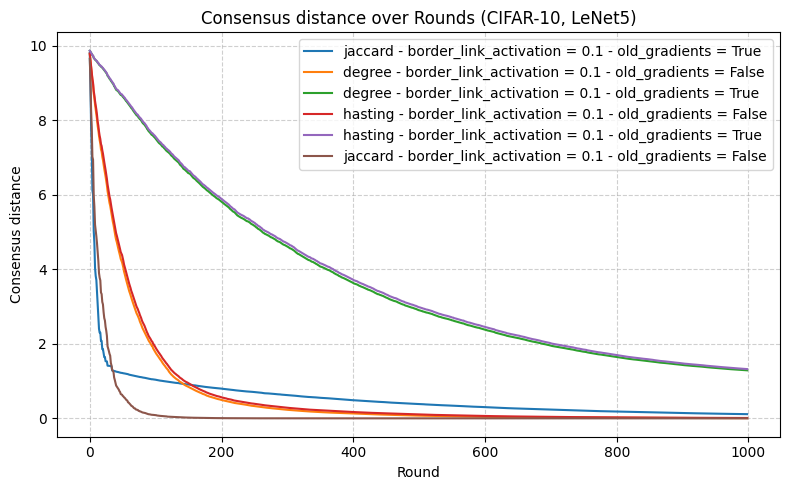

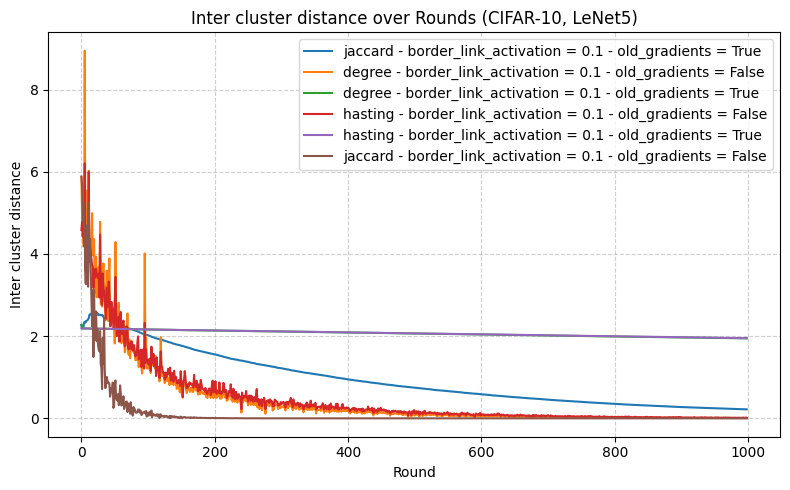

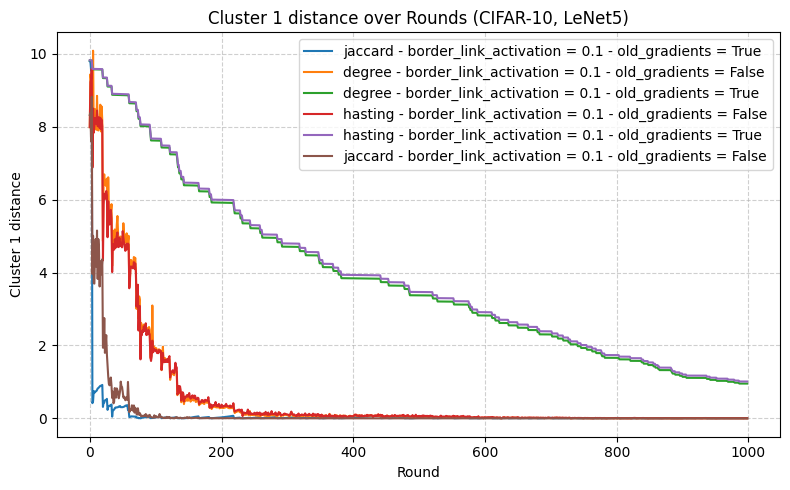

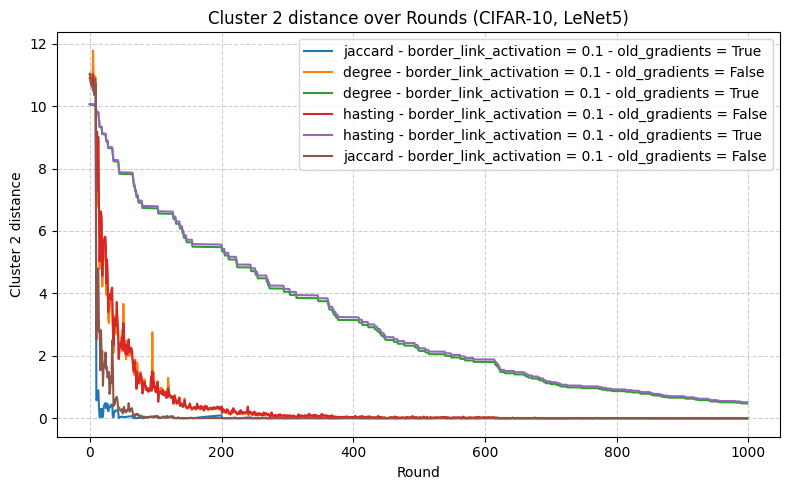

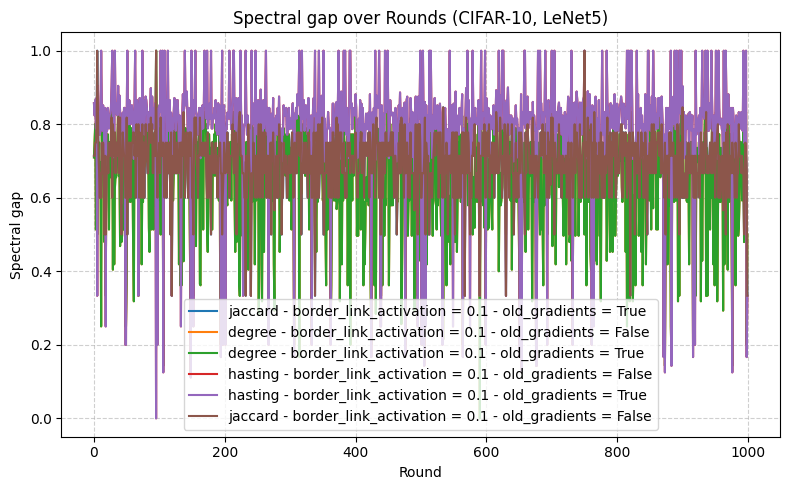

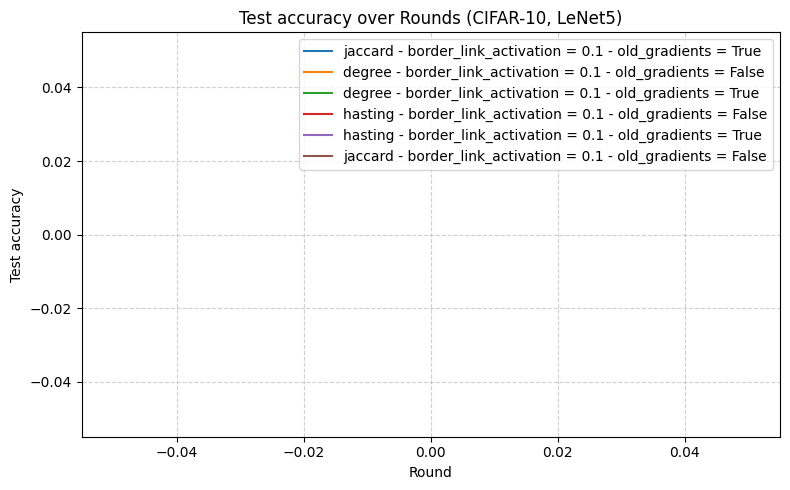

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
keys = list(results.keys())
index_elems = list(results[keys[0]].keys())
epochs = min(1000, min(len(results[k][index_elems[0]]) for k in keys))  
epochs = 1000
start = 0
for index_elem in index_elems:
    plt.figure(figsize=(8, 5))
    if type(results[list(results.keys())[0]][index_elem]) is not list:
        continue
    for key in keys:
        y = results[key].get(index_elem, None)            
        y = y[start:epochs]
        rounds = np.arange(start, start + len(y))
        label = f"{key.split('_')[-1]} - border_link_activation = {results[key]['border_link_activation']} - old_gradients = {results[key]['old_gradients']}"
        plt.plot(rounds, y, label=label)
    
    plt.xlabel("Round")
    plt.ylabel(index_elem.replace('_', ' ').capitalize())
    plt.title(f"{index_elem.replace('_', ' ').capitalize()} over Rounds (CIFAR-10, LeNet5)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()



In [12]:
for log_dir in os.listdir(log_path):
    log_file  = f'{log_path}/{log_dir}'
    if os.path.isfile(log_file):
        continue
    if log_dir == "15-38-50":
        continue
    with open(f'{log_file}/fixed_value_training.log', 'r') as f:
        data = f.read()
    config_file = OmegaConf.load(f'{log_file}/.hydra/config.yaml') 
    with open(f'{log_file}/graph.pickle', 'rb') as f:
        graph = pickle.load(f)  
    if config_file.mixing_matrix == 'matcha':
        algebric_values = []
        W = list()
        n_nodes = len(graph.nodes)
        subgraphs = getSubGraphs(graph, n_nodes)
        laplacians = graphToLaplacian(subgraphs, n_nodes)
        probas = getProbability(laplacians, 2/5)
        alpha = getAlpha(laplacians, probas, n_nodes)
        for _ in range(config_file.train.rounds):
            L_k = np.sum([laplacians[i] for i in range(len(subgraphs)) if np.random.random() < probas[i]], axis=0)
            eigenval = sorted(np.linalg.eig(np.eye(n_nodes) - alpha * L_k).eigenvalues, reverse=True)
            algebric_values.append(1 -max(abs(eigenval[1]), abs(eigenval[-1])))

FileNotFoundError: [Errno 2] No such file or directory: 'DSGD_shinkhorn/2025-11-25/11-26-35/jaccard-True-lenet5/fixed_value_training.log'